# UFC PREDICTION MODEL 1.0 (XGBoost) ###

Notes:
- To start enviroment: venv\Scripts\Activate.ps1

### Import required libraries

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # for model extraction
import matplotlib.pyplot as plt

### Import Data

In [ ]:
df = pd.read_csv("../Data\large_dataset.csv")

# Reverse the dataset to begin with the oldest fight
df = df.iloc[::-1].reset_index(drop=True)


<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\fancy\AppData\Local\Temp\ipykernel_42628\3763960240.py:1: SyntaxWarning: invalid escape sequence '\l'
  df = pd.read_csv("../Data\large_dataset.csv")


### Setup Variables

In [27]:
# Create binary winner label
df['winner_binary'] = df['winner'].map({'Red': 1, 'Blue': 0})

diff_features = [
    'SLpM_total_diff', 'SApM_total_diff', 'sig_str_acc_total_diff',
    'td_acc_total_diff', 'str_def_total_diff', 'td_def_total_diff',
    'sub_avg_diff', 'td_avg_diff', 'age_diff', 'height_diff', 'reach_diff', 'wins_total_diff', 'losses_total_diff'
]

# Drop rows with missing values in key columns
df = df.dropna(subset=diff_features + ['winner_binary'])

# Reverse for chronological ordering
df = df.iloc[::-1].reset_index(drop=True)

# Split dataset
split_idx = int(len(df) * (2 / 3))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Define features and targets
X_train = train_df[diff_features]
y_train = train_df['winner_binary']
X_test = test_df[diff_features]
y_test = test_df['winner_binary']


# .55 Acc Version ----

# # Create binary winner label
# df['winner_binary'] = df['winner'].map({'Red': 1, 'Blue': 0})

# # List of pre-fight columns to generate diffs
# pre_fight_cols = [
#     'SLpM_total', 'SApM_total', 'sig_str_acc_total', 'td_acc_total',
#     'str_def_total', 'td_def_total', 'sub_avg', 'td_avg',
#     'age', 'height', 'weight', 'reach', 'wins_total', 'losses_total'
# ]

# # Compute raw diffs: Red - Blue
# for col in pre_fight_cols:
#     df[f"{col}_diff"] = df[f"r_{col}"] - df[f"b_{col}"]

# # Flip diffs for Blue wins so that all diffs are: winner - loser
# for col in pre_fight_cols:
#     diff_col = f"{col}_diff"
#     df.loc[df['winner_binary'] == 0, diff_col] = -df.loc[df['winner_binary'] == 0, diff_col]

# # 🚫 DO NOT overwrite the label
# # df['winner_binary'] = 1  ← REMOVE THIS LINE

# # Collect only the final diff columns for model input
# diff_features = [f"{col}_diff" for col in pre_fight_cols]

# # Drop rows with missing values in key columns
# df = df.dropna(subset=diff_features + ['winner_binary'])

# # Split data: 2/3 for training, 1/3 for testing
# split_idx = int(len(df) * (2 / 3))
# train_df = df.iloc[:split_idx]
# test_df = df.iloc[split_idx:]

# # Define features and targets
# X_train = train_df[diff_features]
# y_train = train_df['winner_binary']
# X_test = test_df[diff_features]
# y_test = test_df['winner_binary']

### Train the Model

In [28]:
# Train model
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=4,
    verbosity=0
)
model.fit(X_train, y_train)
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,method,'sigmoid'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


### Predict and Evaluate

In [29]:
# Predict + evaluate
y_pred = calibrated.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.65884561238855

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.53      0.47       617
           1       0.79      0.71      0.75      1514

    accuracy                           0.66      2131
   macro avg       0.61      0.62      0.61      2131
weighted avg       0.68      0.66      0.67      2131

Confusion Matrix:
 [[ 325  292]
 [ 435 1079]]


In [30]:
# Save model for external use
joblib.dump(calibrated, "xgb_ufc_model.pkl")


['xgb_ufc_model.pkl']

### Visualize/Analyze

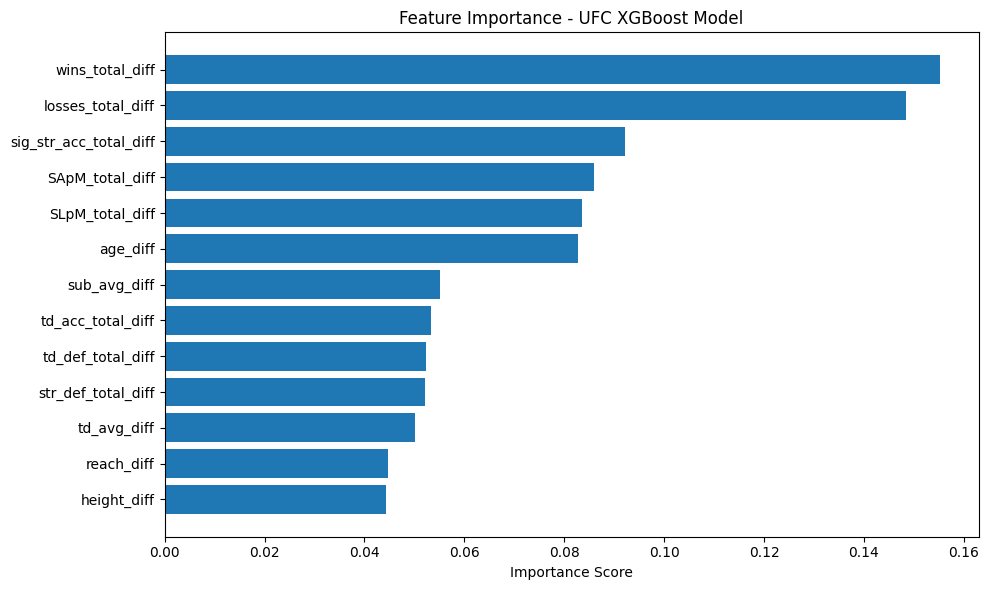

In [31]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': diff_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - UFC XGBoost Model')
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()